In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
path = "/content/gdrive/MyDrive/machine_learning/pertemuan04"

In [3]:
import pandas as pd

df = pd.read_csv(path + "/praktikum_04/data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [6]:
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [7]:
df.duplicated().sum()

np.int64(7308)

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [11]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [12]:
#1. Mapping kolom Stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted' : 1, 'Normal': 0, 'Tall' : 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('int64')

#2. Mapping kolom Jenis Kelamin -> biner
# Laki-laki = 1, Perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype('int')

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    72320
1    20372
Name: count, dtype: int64

Distribusi JK_bin:
 JK_bin
1    46353
0    46339
Name: count, dtype: int64


In [13]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.874162,0.659566,0.037173,0.000636
Tinggi Badan (cm),0.874162,1.000000,0.618453,-0.288216,0.070159
Berat Badan (kg),0.659566,0.618453,1.000000,0.020676,0.043446
Stunting_bin,0.037173,-0.288216,0.020676,1.000000,-0.005187
JK_bin,0.000636,0.070159,0.043446,-0.005187,1.000000


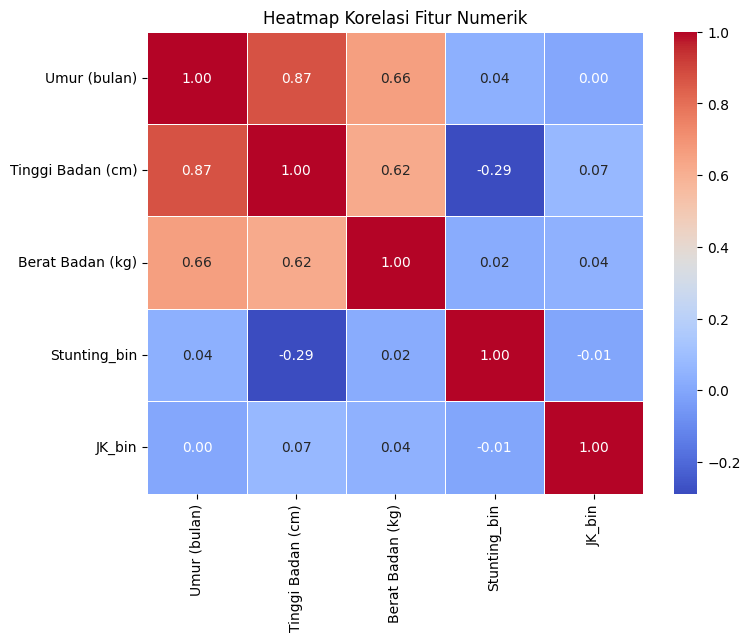

In [14]:
# Visualisasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Fitur Numerik', fontsize=12)
plt.show()

In [15]:
# Fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

# Output:
# X shape: (100000, 4)
# y shape: (100000,)

X shape: (92692, 4)
y shape: (92692,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (74153, 4)
Data uji: (18539, 4)


In [17]:
# Scale hanya fitur numerik, gender langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")

✅ Model Logistic Regression berhasil dilatih.


In [18]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi    : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision  : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall     : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score   : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC    : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi    : 0.9063
Precision  : 0.7139
Recall     : 0.9571
F1-Score   : 0.8178
ROC-AUC    : 0.9651


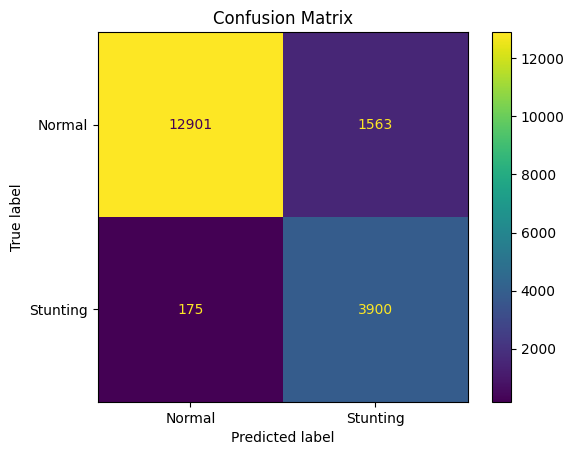

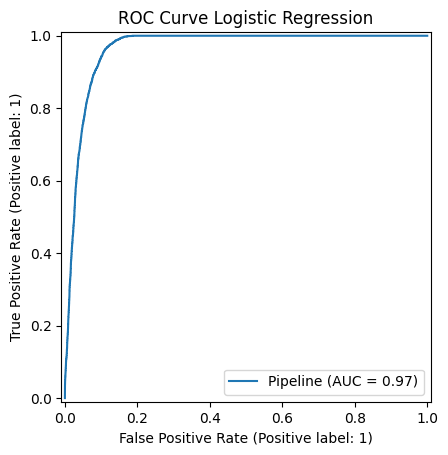

In [19]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal', 'Stunting']
                       ).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.99      0.89      0.94     14464
      Stunting (1)       0.71      0.96      0.82      4075

          accuracy                           0.91     18539
         macro avg       0.85      0.92      0.88     18539
      weighted avg       0.93      0.91      0.91     18539



In [21]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Skor tiap fold: [0.9084093  0.90414801 0.90468227 0.90673212 0.9028482 ]
Rata-rata akurasi: 0.9053639814725255
Standar deviasi: 0.001970695381359219


In [22]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coeffs = clf.named_steps['model'].coef_[0]
odds = np.exp(coeffs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coeffs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.661420,5775.733054
3,JK_bin,1.726339,5.620042
2,Berat Badan (kg),0.653153,1.921590
1,Tinggi Badan (cm),-10.742834,0.000022


In [23]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0] # 1=Laki-Laki, 0=Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.998346,1
1,10,72.5,7.8,0,0.001810,0
